# Header

In [1]:
import sys
print(sys.version)
print(sys.executable)

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
/home/cz136/anaconda3/envs/balrog/bin/python


In [2]:
import matplotlib
# matplotlib.use("agg")
import matplotlib.pyplot as plt
import pylab
import numpy as np
import h5py
from astropy.io import fits
from tqdm import tqdm

In [3]:
detect = fits.open('/lsst/troxel/balrog/balrog_detection_catalog-v1.2.fits')[-1]
phot   = fits.open('/lsst/troxel/balrog/balrog_matched_catalog_flatten.fits')
id_balrog = fits.open('/lsst/troxel/balrog/balrog_mcal_bal_ids_v1.2.fits')

#all objects riz
mcal   = h5py.File('/lsst/troxel/balrog/balrog_mcal_stack-y3v02-0-riz-mcal-v1.2.h5','r')['catalog'] #with neighbor
mcal1  = h5py.File('/lsst/troxel/balrog/balrog_mcal_stack-y3v02-0-riz-noNB-mcal-v1.2.h5','r')['catalog'] #no neighbor

#only coadded objects riz
mcal2   = h5py.File('/lsst/troxel/balrog/balrog_mcal_stack-y3v02-0-riz-mcal-1.3.h5','r')['catalog'] #with neighbor
mcal3  = h5py.File('/lsst/troxel/balrog/balrog_mcal_stack-y3v02-0-riz-noNB-mcal-1.3.h5','r')['catalog'] #no neighbor

#all objects griz
mcal4   = h5py.File('/lsst/troxel/balrog/balrog_mcal_stack-y3v02-0-griz-mcal-1.3.h5','r')['catalog'] #with neighbor
mcal5  = h5py.File('/lsst/troxel/balrog/balrog_mcal_stack-y3v02-0-griz-noNB-mcal-1.3.h5','r')['catalog'] #no neighbor

In [4]:
name_array = ["mcal","mcal1","mcal2","mcal3","mcal4","mcal5"]
catalog_array = [mcal,mcal1,mcal2,mcal3,mcal4,mcal5]

In [5]:
def get_np_unsheared_array(catalog_array):
    catalog_array_unsheared=[]
    for catalog in catalog_array:
        data_dict={}
        for key in list(catalog['unsheared'].keys()):
            data_dict[key]=catalog['unsheared'][key].value
        catalog_array_unsheared.append(data_dict)
    return (catalog_array_unsheared)

In [6]:
catalog_array_unsheared=get_np_unsheared_array(catalog_array)
keys_array = [list(mcal.keys()) for mcal in catalog_array_unsheared]

/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [7]:
SNR_CUT = 10
SIZE_RATIO_CUT = 0.5
T_CUT = 1000

# Functions

In [8]:
def sort_by_bal_id(catalog):
    catalog_sorted = {}
    order = catalog['bal_id'].argsort()
    for key in catalog.keys():
        catalog_sorted[key] = catalog[key][order]
    return (catalog_sorted)

In [9]:
def get_true_dict(true_data):
    true_data_dict = {}
    for key in true_data.columns:
        true_data_dict[key.name] = true_data[key.name]
    return (true_data_dict)

In [10]:
def masking(catalog,SNR_CUT,SIZE_RATIO_CUT,T_CUT):
    snr_mask = np.ma.masked_greater(catalog['snr'][:],SNR_CUT)
    size_ratio_mask = np.ma.masked_greater(catalog['size_ratio'][:],SIZE_RATIO_CUT)
    T_mask = np.ma.masked_less(catalog['T'],T_CUT)
    mask_temp = np.logical_and(snr_mask.mask, size_ratio_mask.mask)
    mask = np.logical_and(mask_temp, T_mask.mask)
    return ([snr_mask,size_ratio_mask,T_mask,mask]) #index 3 is the final mask

In [11]:
def get_mask(catalog_array_unsheared):
    mask_array = []
    for catalog in catalog_array_unsheared:
        mask_array.append(masking(catalog,SNR_CUT,SIZE_RATIO_CUT,T_CUT))
    return (mask_array)

In [12]:
def print_mask():
    for i,catalog in enumerate(catalog_array_unsheared):
        print ("For {:5}, snr > {:3} mask cuts {:8} elements, size_ratio > {:4} mask cuts {:8} elements, T > {:5} mask cuts {:5} elements".format
          (name_array[i],SNR_CUT,np.sum(~mask_array[i][0].mask),SIZE_RATIO_CUT,np.sum(~mask_array[i][1].mask),T_CUT,np.sum(~mask_array[i][2].mask)))

In [13]:
def mask_catalog_arrays(catalog_array,mask_array):
    masked_catalog = []
    for i,catalog in enumerate(catalog_array):
        data_dict = {}
        for key in list(catalog.keys()):
            data_dict[key] = catalog[key][mask_array[i]]
        masked_catalog.append(data_dict)
    return (masked_catalog)

In [14]:
def get_unique_dict(old_dict):
    new_dict={}
    temp_dict,order=np.unique(old_dict['bal_id'],return_index=True)
    for key in list(old_dict.keys()):
        new_dict[key]=old_dict[key][order]
    return(new_dict)

In [15]:
def sort_dict_by_bal(old_dict):
    new_dict={}
    order= old_dict['bal_id'].argsort()
    for key in list(old_dict.keys()):
        new_dict[key]=old_dict[key][order]
    return(new_dict)

In [16]:
def get_intersected_mask(catalog1,catalog2):
    
    id_array_1 = catalog1['bal_id'][:]
    id_array_2 = catalog2['bal_id'][:]

    mask1 = np.in1d(id_array_1,id_array_2)
    mask2 = np.in1d(id_array_2,id_array_1)

    if np.sum(mask1)==np.sum(mask2):
        print("The number of elements after taking the intersection of two sets are {}".format(np.sum(mask1)))
        print("The intersection operation takes {} elements from array1".format(len(id_array_1)-np.sum(mask1)))
        print("The intersection operation takes {} elements from array2".format(len(id_array_2)-np.sum(mask2)))

    if np.all((np.equal(id_array_1[mask1],id_array_2[mask2]))):
        print("The balrog ids are two identical arrays after masking.")
        
    return(mask1,mask2)

In [17]:
mask_array = get_mask(catalog_array_unsheared)

In [18]:
mask_array = [mask[3] for mask in mask_array]

In [19]:
masked_catalog = mask_catalog_arrays(catalog_array_unsheared,mask_array)

In [ ]:
relavant_catalogs=masked_catalog[2:6]
# # new_relavant=[]
# for catalog in relavant_catalogs:
#     new_relavant.append()get_unique_dict(catalog):
#     new_dict={}
#     temp_dict,order=np.unique(old_dict['bal_id'],return_index=True)
#     for key in list(old_dict.keys()):
#         new_dict[key]=old_dict[key][order]
#     return(new_dict)

# Getting dictionary arrays

In [21]:
cols=phot[1].columns
true_data = phot[1].data

true_dict = get_true_dict(true_data)

In [22]:
true_dict_unique=get_unique_dict(true_dict);

In [23]:
true_dict_unique_sorted=sort_dict_by_bal(true_dict_unique)

In [24]:
def get_positive_g_mask(true_dict):
    g1_mask = np.ma.masked_greater(true_dict['true_cm_g_1'],0)
    g2_mask = np.ma.masked_greater(true_dict['true_cm_g_2'],0)
    g_mask = np.logical_and(g1_mask.mask, g2_mask.mask)
    return(g_mask)

In [25]:
def get_negative_g_mask(true_dict):
    g1_mask = np.ma.masked_less(true_dict['true_cm_g_1'],0)
    g2_mask = np.ma.masked_less(true_dict['true_cm_g_2'],0)
    g_mask = np.logical_and(g1_mask.mask, g2_mask.mask)
    return(g_mask)

In [26]:
positive_g_mask=get_positive_g_mask(true_dict_unique_sorted)
negative_g_mask=get_negative_g_mask(true_dict_unique_sorted)

In [27]:
true_positive_g=mask_catalog_arrays([true_dict_unique_sorted],[positive_g_mask])[0]
true_negative_g=mask_catalog_arrays([true_dict_unique_sorted],[negative_g_mask])[0]

In [28]:
positive_filtered=[]
positive_true=[]
for i,catalog in enumerate(relavant_catalogs):
    positive_mask_true,positive_mask_mcal = get_intersected_mask(true_positive_g,catalog)
    positive_filtered.append(mask_catalog_arrays([catalog],[positive_mask_mcal])[0])
    positive_true.append(mask_catalog_arrays([true_positive_g],[positive_mask_true])[0])

The number of elements after taking the intersection of two sets are 320407
The intersection operation takes 768001 elements from array1
The intersection operation takes 967267 elements from array2
The number of elements after taking the intersection of two sets are 450626
The intersection operation takes 637782 elements from array1
The intersection operation takes 1365985 elements from array2
The number of elements after taking the intersection of two sets are 250457
The intersection operation takes 837951 elements from array1
The intersection operation takes 758531 elements from array2
The number of elements after taking the intersection of two sets are 384605
The intersection operation takes 703803 elements from array1
The intersection operation takes 1169824 elements from array2


In [29]:
negative_filtered=[]
negative_true=[]
for i,catalog in enumerate(relavant_catalogs):
    negative_mask_true,negative_mask_mcal = get_intersected_mask(true_negative_g,catalog)
    negative_filtered.append(mask_catalog_arrays([catalog],[negative_mask_mcal])[0])
    negative_true.append(mask_catalog_arrays([true_negative_g],[negative_mask_true])[0])

The number of elements after taking the intersection of two sets are 317724
The intersection operation takes 764411 elements from array1
The intersection operation takes 969950 elements from array2
The number of elements after taking the intersection of two sets are 445397
The intersection operation takes 636738 elements from array1
The intersection operation takes 1371214 elements from array2
The number of elements after taking the intersection of two sets are 248804
The intersection operation takes 833331 elements from array1
The intersection operation takes 760184 elements from array2
The number of elements after taking the intersection of two sets are 380589
The intersection operation takes 701546 elements from array1
The intersection operation takes 1173840 elements from array2


In [30]:
print (len(negative_filtered))

4


# Intersect mcal2/3 mcal4/5

In [31]:
def intersect_the_same_catalog():
    duo_intersected_array_positive=[]
    duo_intersected_array_negative=[]
    for i in [0,2]:
        (mask1,mask2)=get_intersected_mask(positive_filtered[i],positive_filtered[i+1])
        (mask3,mask4)=get_intersected_mask(negative_filtered[i],negative_filtered[i+1])
        mask_array=[mask1,mask2,mask3,mask4]
        duo_intersected_array_positive.append(mask_catalog_arrays([positive_filtered[i]],[mask_array[0]])[0])
        duo_intersected_array_positive.append(mask_catalog_arrays([positive_filtered[i+1]],[mask_array[1]])[0])
        duo_intersected_array_negative.append(mask_catalog_arrays([negative_filtered[i]],[mask_array[2]])[0])
        duo_intersected_array_negative.append(mask_catalog_arrays([negative_filtered[i+1]],[mask_array[3]])[0])
    return(duo_intersected_array_positive,duo_intersected_array_negative)

In [32]:
(nor_positive,nor_negative) = intersect_the_same_catalog()

The number of elements after taking the intersection of two sets are 272818
The intersection operation takes 47589 elements from array1
The intersection operation takes 177808 elements from array2
The balrog ids are two identical arrays after masking.
The number of elements after taking the intersection of two sets are 270876
The intersection operation takes 46848 elements from array1
The intersection operation takes 174521 elements from array2
The balrog ids are two identical arrays after masking.
The number of elements after taking the intersection of two sets are 215145
The intersection operation takes 35312 elements from array1
The intersection operation takes 169460 elements from array2
The balrog ids are two identical arrays after masking.
The number of elements after taking the intersection of two sets are 213617
The intersection operation takes 35187 elements from array1
The intersection operation takes 166972 elements from array2
The balrog ids are two identical arrays after m

In [33]:
positive_filtered=[]
positive_true=[]
for i,catalog in enumerate(nor_positive):
    positive_mask_true,positive_mask_mcal = get_intersected_mask(true_positive_g,catalog)
    positive_filtered.append(mask_catalog_arrays([catalog],[positive_mask_mcal])[0])
    positive_true.append(mask_catalog_arrays([true_positive_g],[positive_mask_true])[0])

The number of elements after taking the intersection of two sets are 272818
The intersection operation takes 815590 elements from array1
The intersection operation takes 0 elements from array2
The number of elements after taking the intersection of two sets are 272818
The intersection operation takes 815590 elements from array1
The intersection operation takes 0 elements from array2
The number of elements after taking the intersection of two sets are 215145
The intersection operation takes 873263 elements from array1
The intersection operation takes 0 elements from array2
The number of elements after taking the intersection of two sets are 215145
The intersection operation takes 873263 elements from array1
The intersection operation takes 0 elements from array2


In [34]:
negative_filtered=[]
negative_true=[]
for i,catalog in enumerate(nor_negative):
    negative_mask_true,negative_mask_mcal = get_intersected_mask(true_negative_g,catalog)
    negative_filtered.append(mask_catalog_arrays([catalog],[negative_mask_mcal])[0])
    negative_true.append(mask_catalog_arrays([true_negative_g],[negative_mask_true])[0])

The number of elements after taking the intersection of two sets are 270876
The intersection operation takes 811259 elements from array1
The intersection operation takes 0 elements from array2
The number of elements after taking the intersection of two sets are 270876
The intersection operation takes 811259 elements from array1
The intersection operation takes 0 elements from array2
The number of elements after taking the intersection of two sets are 213617
The intersection operation takes 868518 elements from array1
The intersection operation takes 0 elements from array2
The number of elements after taking the intersection of two sets are 213617
The intersection operation takes 868518 elements from array1
The intersection operation takes 0 elements from array2


In [35]:
for catalog in nor_negative:
    print (len(catalog['bal_id']))
print (len(negative_true[0]['bal_id']))

270876
270876
213617
213617
270876


In [36]:
print (np.equal(nor_positive[2]['e_1'],nor_positive[3]['e_1']))

[False False False ... False False False]


In [37]:
print (np.equal(negative_true[0]['true_cm_g_1'],negative_true[1]['true_cm_g_1']).all())

True


In [38]:
positive_filtered=nor_positive
negative_filtered=nor_negative

In [39]:
def get_R(mcal,true):
    e1=np.mean(mcal['e_1'])
    e2=np.mean(mcal['e_2'])
    g1=np.mean(true['true_cm_g_1'])
    g2=np.mean(true['true_cm_g_2'])
    r11=e1/g1
    r12=e1/g2
    r21=e2/g1
    r22=e2/g2
    return([[r11,r12],[r21,r22]],[[e1,e2],[g1,g2]])

In [40]:
R_array_positive=[]
eg_array_positive=[]
for i in range(4):
    R_array_positive.append(get_R(positive_filtered[i],positive_true[i])[0])
    eg_array_positive.append(get_R(positive_filtered[i],positive_true[i])[1])

In [41]:
R_array_negative=[]
eg_array_negative=[]
for i in range(4):
    R_array_negative.append(get_R(negative_filtered[i],negative_true[i])[0])
    eg_array_negative.append(get_R(negative_filtered[i],negative_true[i])[1])

In [42]:
real_R_array_positive=[]
for i in range(4):
    r11=np.mean(positive_filtered[i]['R11'])
    r12=np.mean(positive_filtered[i]['R12'])
    r21=np.mean(positive_filtered[i]['R21'])
    r22=np.mean(positive_filtered[i]['R22'])
    real_R_array_positive.append([[r11,r12],[r21,r22]])

In [43]:
real_R_array_negative=[]
for i in range(4):
    r11=np.mean(negative_filtered[i]['R11'])
    r12=np.mean(negative_filtered[i]['R12'])
    r21=np.mean(negative_filtered[i]['R21'])
    r22=np.mean(negative_filtered[i]['R22'])
    real_R_array_negative.append([[r11,r12],[r21,r22]])

In [44]:
for i,R_array in enumerate(R_array_negative):
    e1_error=np.std(negative_filtered[i]['e_1'])/np.sqrt(float(len(negative_filtered[i]['e_1'])))
    e2_error=np.std(negative_filtered[i]['e_2'])/np.sqrt(float(len(negative_filtered[i]['e_2'])))
    
    g1_error=np.std(negative_true[i]['true_cm_g_1'])/np.sqrt(float(len(negative_true[i]['true_cm_g_1'])))
    g2_error=np.std(negative_true[i]['true_cm_g_2'])/np.sqrt(float(len(negative_true[i]['true_cm_g_2'])))
    
    e1_mean=np.mean(negative_filtered[i]['e_1'])
    e2_mean=np.mean(negative_filtered[i]['e_2'])
    
    g1_mean=np.mean(negative_true[i]['true_cm_g_1'])
    g2_mean=np.mean(negative_true[i]['true_cm_g_2'])
    
    R11_error=np.sqrt((1/g1_mean)**2 * e1_error**2 + (e1_mean/(g1_mean**2))**2*g1_error**2)
    R22_error=np.sqrt((1/g2_mean)**2 * e2_error**2 + (e2_mean/(g2_mean**2))**2*g2_error**2)
    
    R_11_mean=np.mean(negative_filtered[i]['R11'])
    R_22_mean=np.mean(negative_filtered[i]['R22'])
    R_11_std=np.std(negative_filtered[i]['R11'])
    R_22_std=np.std(negative_filtered[i]['R22'])

    
    R_11_read_error=R_11_std/np.sqrt(float(len(negative_filtered[i]['R11'])))
    R_22_read_error=R_11_std/np.sqrt(float(len(negative_filtered[i]['R22'])))

    
    
    g_prime_1=np.mean(negative_filtered[i]['e_1'])/R_11_mean
    g_prime_2=np.mean(negative_filtered[i]['e_2'])/R_22_mean
    
    g_prime_1_error=np.sqrt((1/R_11_mean)**2 * e1_error**2 + (e1_mean/R_11_mean**2)**2*R_11_read_error**2)
    g_prime_2_error=np.sqrt((1/R_22_mean)**2 * e2_error**2 + (e2_mean/R_22_mean**2)**2*R_22_read_error**2)
    print("For mcal{} with negative g, measured R is".format(i+2))
    for j,row1 in enumerate(R_array):
        print("|{:5.3e} {:5.3e}|".format(*row1))
    print("<e1>={:5.3e}, <e2>={:5.3e}, <g1>={:5.3e}, <g2>={:5.3e}, R11={:5.3e}, R22={:5.3e}".format(*eg_array_negative[i][0],*eg_array_negative[i][1],real_R_array_negative[i][0][0],real_R_array_negative[i][1][1]))
    print("d_e1={:5.3e}, d_e2={:5.3e}".format(e1_error,e2_error))
    print("R11'_error={:5.3e} R22'_error={:5.3e}".format(R11_error,R22_error))
    print("\n")
    print ("g1'={:5.3e}, g2'={:5.3e},".format(g_prime_1,g_prime_2)+" g1'_error={:5.3e}, g2'_error={:5.3e}".format(g_prime_1_error,g_prime_2_error))
    print("\n")
    print("Theoretical R is".format(i+2))
    for j,row1 in enumerate(R_array):
        print("|{:5.3e} {:5.3e}|".format(*real_R_array_negative[i][j]))
    print ("R11'={:5.3e}, R22'={:5.3e}, R11={:5.3e}, R22={:5.3e}".format(R_array_negative[i][0][0],R_array_negative[i][1][1],real_R_array_negative[i][0][0],real_R_array_negative[i][1][1]))
    print("-----------------------------------------------------------------")
    print("\n")


For mcal2 with negative g, measured R is
|7.100e-01 7.247e-01|
|6.932e-01 7.076e-01|
<e1>=-1.415e-01, <e2>=-1.381e-01, <g1>=-1.993e-01, <g2>=-1.952e-01, R11=7.748e-01, R22=7.802e-01
d_e1=3.634e-04, d_e2=3.625e-04
R11'_error=2.197e-03 R22'_error=2.230e-03


g1'=-1.826e-01, g2'=-1.770e-01, g1'_error=6.369e-04, g2'_error=6.229e-04


Theoretical R is
|7.748e-01 -5.918e-02|
|-5.926e-02 7.802e-01|
R11'=7.100e-01, R22'=7.076e-01, R11=7.748e-01, R22=7.802e-01
-----------------------------------------------------------------


For mcal3 with negative g, measured R is
|7.074e-01 7.221e-01|
|6.918e-01 7.062e-01|
<e1>=-1.409e-01, <e2>=-1.378e-01, <g1>=-1.993e-01, <g2>=-1.952e-01, R11=7.699e-01, R22=7.745e-01
d_e1=3.634e-04, d_e2=3.620e-04
R11'_error=2.195e-03 R22'_error=2.226e-03


g1'=-1.831e-01, g2'=-1.780e-01, g1'_error=6.439e-04, g2'_error=6.305e-04


Theoretical R is
|7.699e-01 -5.719e-02|
|-5.868e-02 7.745e-01|
R11'=7.074e-01, R22'=7.062e-01, R11=7.699e-01, R22=7.745e-01
--------------------

In [45]:
for i,R_array in enumerate(R_array_positive):
    e1_error=np.std(positive_filtered[i]['e_1'])/np.sqrt(float(len(positive_filtered[i]['e_1'])))
    e2_error=np.std(positive_filtered[i]['e_2'])/np.sqrt(float(len(positive_filtered[i]['e_2'])))
    g1_error=np.std(positive_true[i]['true_cm_g_1'])/np.sqrt(float(len(positive_true[i]['true_cm_g_1'])))
    g2_error=np.std(positive_true[i]['true_cm_g_2'])/np.sqrt(float(len(positive_true[i]['true_cm_g_2'])))
    e1_mean=np.mean(positive_filtered[i]['e_1'])
    e2_mean=np.mean(positive_filtered[i]['e_2'])
    g1_mean=np.mean(positive_true[i]['true_cm_g_1'])
    g2_mean=np.mean(positive_true[i]['true_cm_g_2'])
    R11_error=np.sqrt((1/g1_mean)**2 * e1_error**2 + (e1_mean/(g1_mean**2))**2*g1_error**2)
    R22_error=np.sqrt((1/g2_mean)**2 * e2_error**2 + (e2_mean/(g2_mean**2))**2*g2_error**2)
    
    R_11_mean=np.mean(positive_filtered[i]['R11'])
    R_22_mean=np.mean(positive_filtered[i]['R22'])
    R_11_std=np.std(negative_filtered[i]['R11'])
    R_22_std=np.std(negative_filtered[i]['R22'])
    
    R_11_read_error=R_11_std/np.sqrt(float(len(positive_filtered[i]['R11'])))
    R_22_read_error=R_22_std/np.sqrt(float(len(positive_filtered[i]['R22'])))
    
    g_prime_1=np.mean(positive_filtered[i]['e_1'])/R_11_mean
    g_prime_2=np.mean(positive_filtered[i]['e_2'])/R_22_mean
    
    g_prime_1_error=np.sqrt((1/R_11_mean)**2 * e1_error**2 + (e1_mean/(R_11_mean**2))**2*R_11_read_error**2)
    g_prime_2_error=np.sqrt((1/R_22_mean)**2 * e2_error**2 + (e2_mean/(R_22_mean**2))**2*R_22_read_error**2)

    

    print("For mcal{} with positive g, measured R is".format(i+2))
    for j,row1 in enumerate(R_array):
        print("|{:5.3e} {:5.3e}|".format(*row1))
    print("<e1>={:5.3e}, <e2>={:5.3e}, <g1>={:5.3e}, <g2>={:5.3e}, R11={:5.3e}, R22={:5.3e}".format(*eg_array_positive[i][0],*eg_array_positive[i][1],real_R_array_positive[i][0][0],real_R_array_positive[i][1][1]))
    print("d_e1={:5.3e}, d_e2={:5.3e}".format(e1_error,e2_error))
    print("R11'_error={:5.3e} R22'_error={:5.3e}".format(R11_error,R22_error))
    print("\n")
    print ("g1'={:5.3e}, g2'={:5.3e},".format(g_prime_1,g_prime_2)+" g1'_error={:5.3e}, g2'_error={:5.3e}".format(g_prime_1_error,g_prime_2_error))
    
    print("Theoretical R is".format(i+2))
    for j,row1 in enumerate(R_array):
        print("|{:5.3e} {:5.3e}|".format(*real_R_array_positive[i][j]))
    print ("R11'={:5.3e}, R22'={:5.3e}, R11={:5.3e}, R22={:5.3e}".format(R_array_positive[i][0][0],R_array_positive[i][1][1],real_R_array_positive[i][0][0],real_R_array_positive[i][1][1]))
    print("-----------------------------------------------------------------")

For mcal2 with positive g, measured R is
|7.177e-01 7.467e-01|
|6.844e-01 7.120e-01|
<e1>=1.473e-01, <e2>=1.405e-01, <g1>=2.053e-01, <g2>=1.973e-01, R11=7.738e-01, R22=7.828e-01
d_e1=3.676e-04, d_e2=3.627e-04
R11'_error=2.168e-03 R22'_error=2.212e-03


g1'=1.904e-01, g2'=1.795e-01, g1'_error=6.532e-04, g2'_error=6.182e-04
Theoretical R is
|7.738e-01 -6.377e-02|
|-6.216e-02 7.828e-01|
R11'=7.177e-01, R22'=7.120e-01, R11=7.738e-01, R22=7.828e-01
-----------------------------------------------------------------
For mcal3 with positive g, measured R is
|7.167e-01 7.457e-01|
|6.822e-01 7.097e-01|
<e1>=1.471e-01, <e2>=1.400e-01, <g1>=2.053e-01, <g2>=1.973e-01, R11=7.675e-01, R22=7.772e-01
d_e1=3.665e-04, d_e2=3.619e-04
R11'_error=2.163e-03 R22'_error=2.207e-03


g1'=1.917e-01, g2'=1.802e-01, g1'_error=6.621e-04, g2'_error=6.310e-04
Theoretical R is
|7.675e-01 -6.231e-02|
|-6.083e-02 7.772e-01|
R11'=7.167e-01, R22'=7.097e-01, R11=7.675e-01, R22=7.772e-01
--------------------------------------

In [46]:
print ("For positive_g")
for i in [0,2]:
    print ("The difference beween R matrice in mcal{:5.3e} and mcal{:5.3e} is:".format(i+2,i+3))
    for j in range(2):
        print ("|{:5.3e} {:5.3e}|".format(*(np.array(R_array_positive[i][j])-np.array(R_array_positive[i+1][j]))))

For positive_g
The difference beween R matrice in mcal2.000e+00 and mcal3.000e+00 is:
|9.862e-04 1.026e-03|
|2.212e-03 2.301e-03|
The difference beween R matrice in mcal4.000e+00 and mcal5.000e+00 is:
|2.446e-03 2.562e-03|
|2.935e-03 3.074e-03|


In [47]:
print ("For negative g")
for i in [0,2]:
    print ("The difference beween R matrice in mcal{} and mcal{} is:".format(i+2,i+3))
    for j in range(2):
        print ("|{:5.3e} {:5.3e}|".format(*(np.array(R_array_negative[i][j])-np.array(R_array_negative[i+1][j]))))

For negative g
The difference beween R matrice in mcal2 and mcal3 is:
|2.577e-03 2.630e-03|
|1.416e-03 1.445e-03|
The difference beween R matrice in mcal4 and mcal5 is:
|-4.649e-04 -4.763e-04|
|2.231e-03 2.286e-03|


In [48]:
print ("For positive g")
for i in range(4):
    print("For mcal{}, the diffrence between measured and theoretical R is".format(i+2))
    for j in range(2):
        print ("|{:5.3e} {:5.3e}|".format(*(np.array(R_array_positive[i][j])-np.array(real_R_array_positive[i][j])))) 

For positive g
For mcal2, the diffrence between measured and theoretical R is
|-5.607e-02 8.105e-01|
|7.465e-01 -7.076e-02|
For mcal3, the diffrence between measured and theoretical R is
|-5.072e-02 8.080e-01|
|7.430e-01 -6.747e-02|
For mcal4, the diffrence between measured and theoretical R is
|-6.822e-02 8.298e-01|
|7.501e-01 -7.738e-02|
For mcal5, the diffrence between measured and theoretical R is
|-6.174e-02 8.176e-01|
|7.443e-01 -7.673e-02|


In [49]:
print ("For negative g")
for i in range(4):
    print("For mcal{}, the diffrence between measured and theoretical R is".format(i+2))
    for j in range(2):
        print ("|{:5.3e} {:5.3e}|".format(*(np.array(R_array_negative[i][j])-np.array(real_R_array_negative[i][j])))) 

For negative g
For mcal2, the diffrence between measured and theoretical R is
|-6.482e-02 7.839e-01|
|7.525e-01 -7.255e-02|
For mcal3, the diffrence between measured and theoretical R is
|-6.254e-02 7.793e-01|
|7.505e-01 -6.835e-02|
For mcal4, the diffrence between measured and theoretical R is
|-8.032e-02 7.887e-01|
|7.597e-01 -8.046e-02|
For mcal5, the diffrence between measured and theoretical R is
|-7.253e-02 7.912e-01|
|7.555e-01 -7.975e-02|


# Fitting e_i = m_i * g + c

In [50]:
intersected_masks=[get_intersected_mask(true_dict_unique_sorted,catalog) for catalog in relavant_catalogs]

The number of elements after taking the intersection of two sets are 1287674
The intersection operation takes 3095231 elements from array1
The intersection operation takes 0 elements from array2
The number of elements after taking the intersection of two sets are 1816611
The intersection operation takes 2566294 elements from array1
The intersection operation takes 0 elements from array2
The number of elements after taking the intersection of two sets are 1008988
The intersection operation takes 3373917 elements from array1
The intersection operation takes 0 elements from array2
The number of elements after taking the intersection of two sets are 1554429
The intersection operation takes 2828476 elements from array1
The intersection operation takes 0 elements from array2


In [51]:
intersected_masks_for_mcal=[mask[1] for mask in intersected_masks]
intersected_masks_for_true=[mask[0] for mask in intersected_masks]

In [52]:
intersected_clipped_array=mask_catalog_arrays(relavant_catalogs,intersected_masks_for_mcal)

In [53]:
four_true_dicts=[true_dict_unique_sorted for i in range(4)]

In [54]:
intersected_clipped_true=mask_catalog_arrays(four_true_dicts,intersected_masks_for_true)

In [55]:
def get_cm(true_dict,mcal_dict):
        y1=mcal_dict['e_1']
        x1=true_dict['true_cm_g_1']
        y2=mcal_dict['e_2']
        x2=true_dict['true_cm_g_2']
        m1,c1=np.polyfit(x1,y1,1)
        m2,c2=np.polyfit(x2,y2,1)
        return([[m1,c1],[m2,c2]])

In [56]:
cm_array=[get_cm(intersected_clipped_true[i],intersected_clipped_array[i]) for i in range(4)]

In [57]:
cm_array_positive=[get_cm(positive_true[i],positive_filtered[i]) for i in range(4)]

In [58]:
cm_array_negative=[get_cm(negative_true[i],negative_filtered[i]) for i in range(4)]

In [59]:
def print_cm(cm_array):
    for i,matrix in enumerate(cm_array):
        print("For mcal{}, m1={:10.3e},c1={:10.3e},m2={:10.3e},c2={:10.3e}".format((i+2),*matrix[0],*matrix[1]))

In [60]:
print_cm(cm_array)

For mcal2, m1= 7.668e-04,c1= 1.897e-03,m2=-1.142e-03,c2= 3.495e-04
For mcal3, m1= 5.635e-04,c1= 2.420e-03,m2= 2.411e-04,c2= 6.351e-04
For mcal4, m1=-6.717e-04,c1= 1.741e-03,m2=-9.173e-04,c2= 5.626e-04
For mcal5, m1=-9.965e-04,c1= 2.446e-03,m2= 4.289e-04,c2= 7.195e-04


In [61]:
print_cm(cm_array_positive)

For mcal2, m1= 1.397e-03,c1= 1.471e-01,m2=-3.002e-03,c2= 1.411e-01
For mcal3, m1=-1.247e-03,c1= 1.474e-01,m2=-6.743e-04,c2= 1.402e-01
For mcal4, m1= 1.512e-03,c1= 1.480e-01,m2=-1.700e-04,c2= 1.405e-01
For mcal5, m1= 2.186e-03,c1= 1.474e-01,m2= 4.565e-04,c2= 1.398e-01


In [62]:
print_cm(cm_array_negative)

For mcal2, m1= 2.809e-03,c1=-1.409e-01,m2=-7.016e-04,c2=-1.383e-01
For mcal3, m1= 4.042e-03,c1=-1.401e-01,m2= 5.362e-04,c2=-1.377e-01
For mcal4, m1=-3.612e-04,c1=-1.412e-01,m2=-9.481e-04,c2=-1.381e-01
For mcal5, m1=-1.431e-03,c1=-1.415e-01,m2= 1.179e-03,c2=-1.373e-01


In [63]:
x1_array=[true_dict['true_cm_g_1'] for true_dict in intersected_clipped_true]
x2_array=[true_dict['true_cm_g_2'] for true_dict in intersected_clipped_true]
y1_array=[mcal_dict['e_1'] for mcal_dict in intersected_clipped_array]
y2_array=[mcal_dict['e_2'] for mcal_dict in intersected_clipped_array]

In [64]:
x3_array=[true_dict['true_cm_g_1'] for true_dict in positive_true]
x4_array=[true_dict['true_cm_g_2'] for true_dict in positive_true]
y3_array=[mcal_dict['e_1'] for mcal_dict in positive_filtered]
y4_array=[mcal_dict['e_2'] for mcal_dict in positive_filtered]

In [65]:
x5_array=[true_dict['true_cm_g_1'] for true_dict in negative_true]
x6_array=[true_dict['true_cm_g_2'] for true_dict in negative_true]
y5_array=[mcal_dict['e_1'] for mcal_dict in negative_filtered]
y6_array=[mcal_dict['e_2'] for mcal_dict in negative_filtered]

In [66]:
colors=(0,0,0)
area=0.01
def plot_scatter(x,y,cm):
    plt.scatter(x,y,s=area,c=colors,alpha=0.5)
    x_range=np.linspace(0,1)
    plt.plot(x_range,cm[0]*x_range+cm[1])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


FileNotFoundError: [Errno 2] No such file or directory: 'scatter/mcal2g1e1.png'

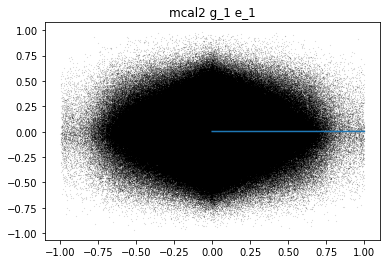

In [67]:
for i in range(4):
    plt.figure()
    plot_scatter(x1_array[i],y1_array[i],cm_array[i][0])
    plt.title("mcal{} g_1 e_1".format(i+2))
    plt.savefig("scatter/mcal{}g1e1".format(i+2),dpi=300)
    plt.close()
    plt.figure()
    plot_scatter(x2_array[i],y2_array[i],cm_array[i][1])
    plt.title("mcal{} g_2 e_2".format(i+2))
    plt.savefig("scatter/mcal{}g2e2".format(i+2),dpi=300)
    plt.close()

In [ ]:
for i in range(4):
    plt.figure()
    plot_scatter(x3_array[i],y3_array[i],cm_array_positive[i][0])
    plt.title("mcal{} g_1 e_1_positive".format(i+2))
    plt.savefig("scatter/mcal{}g1e1_positive".format(i+2),dpi=300)
    plt.close()
    plt.figure()
    plot_scatter(x4_array[i],y4_array[i],cm_array[i][1])
    plt.title("mcal{} g_2 e_2_positive".format(i+2))
    plt.savefig("scatter/mcal{}g2e2_positive".format(i+2),dpi=300)
    plt.close()

In [ ]:
for i in range(4):
    plt.figure()
    plot_scatter(x3_array[i],y3_array[i],cm_array_positive[i][0])
    plt.title("mcal{} g_1 e_1_negative".format(i+2))
    plt.savefig("scatter/mcal{}g1e1_negative".format(i+2),dpi=300)
    plt.close()
    plt.figure()
    plot_scatter(x4_array[i],y4_array[i],cm_array[i][1])
    plt.title("mcal{} g_2 e_2_negative".format(i+2))
    plt.savefig("scatter/mcal{}g2e2_negative".format(i+2),dpi=300)
    plt.close()

In [ ]:
for i in [0,2]:
    print(i)

# healpix

In [ ]:
from astropy_healpix import HEALpix
from astropy.coordinate import icrs

